In [1]:
import pandas as pd
import numpy as np
import scipy.signal
import seaborn as sns
import matplotlib.ticker as ticker

In [3]:
path = "/home/francisco/tps/datos/tp2/"
load_path = path + "{}.hdf"

N_P = 2
N_S = 2
pacientes_P = []
pacientes_S = []
for load_name, N, dest in [("P", N_P, pacientes_P), ("S", N_S, pacientes_S)]:
    for paciente in [load_name + "{:02d}".format(i) for i in range(1, 1 + N)]:
        dest.append(pd.read_hdf(load_path.format(paciente)))


a1

In [5]:
dfs1 = [pacientes_P[i].loc[i+1,:,[8,44,80,131,185],:] for i in range(N)]

In [6]:
sensor_means = [df.groupby(['epoch', 'tiempo']).mean() for df in dfs1]

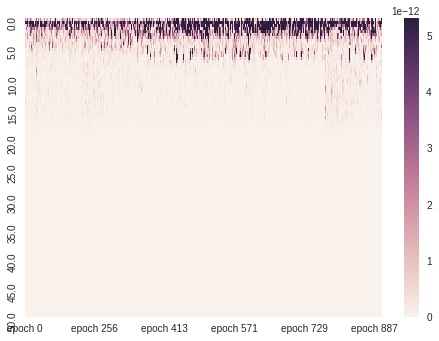

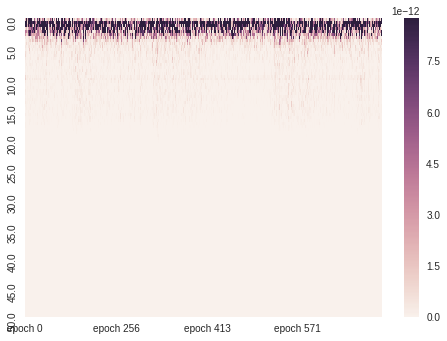

In [7]:
for sm in sensor_means:
    frecuencias = sm.groupby(['epoch']).apply(lambda x: scipy.signal.welch(x['valores'], fs=100, nperseg = 200))
    data = {'epoch {}'.format(i): f for i,f in enumerate(map(lambda x: x[1], frecuencias.values))}
    index = frecuencias.values[0][0]
    f_df = pd.DataFrame(data=data, index=index)
    
    g = sns.heatmap(f_df, xticklabels=175, yticklabels=10, robust=True)
    sns.plt.show()


a2

In [9]:
epoch_means = [df.groupby(['sensor', 'tiempo']).mean() for df in pacientes_P]

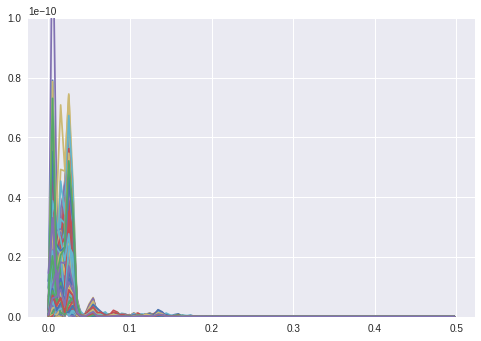

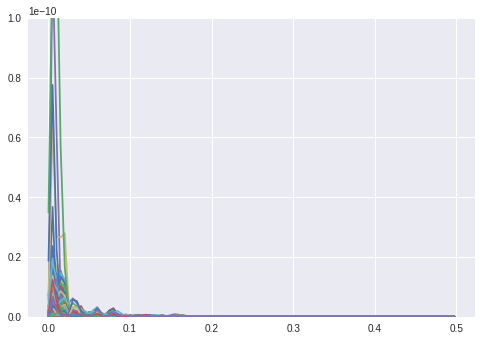

In [10]:
for em in epoch_means:
    for sensor, df_g in em.groupby(['sensor']):
        f, P = scipy.signal.welch(df_g['valores'].values, nperseg=201)
        sns.plt.plot(f, P)
    axes = sns.plt.gca()
    axes.set_ylim([0,10**-10])
    sns.plt.show()

b <b>No entiendo porque los valores de f quedan entre 0 y 0.5 en lugar de quedar entre 0 y 50</b>

In [19]:
def calcular_frecuencias(f, P):
    return {
        'delta': P[f<0.04].sum(),
        'theta': P[(0.04<=f) & (f<0.08)].sum(),
        'alpha': P[(0.08<=f) & (f<0.13)].sum(),
        'beta': P[(0.13<=f) & (f<0.30)].sum(),
        'gamma': P[0.30<=f].sum()
    }
    

alphas_P = {}
alphas_S = {}
for alphas, pacientes in [(alphas_P, pacientes_P), (alphas_S, pacientes_S)]:
    for i, p in enumerate(pacientes):
        frecuencia_media = p.groupby(['tiempo']).mean()
        f, P = scipy.signal.welch(frecuencia_media['valores'], nperseg=201)
        valores_bandas = calcular_frecuencias(f,P)
        alphas[i] = valores_bandas['alpha']

df_alphas = pd.DataFrame({
    "Capacidad cognitiva": (["Normales"] * N_S) + (["Reducidas"] * N_P),
    "Banda alpha": list(alphas_S.values()) + list(alphas_P.values())
})



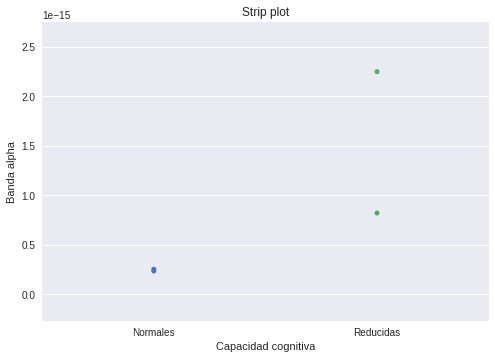

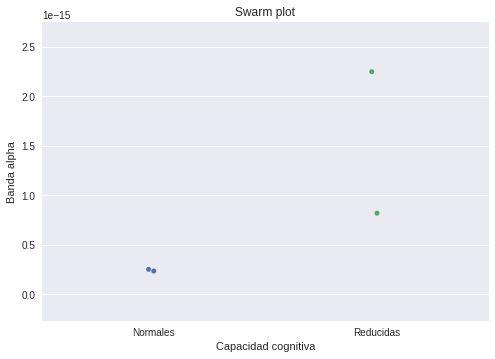

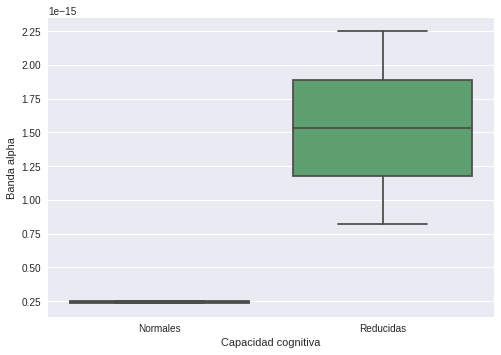

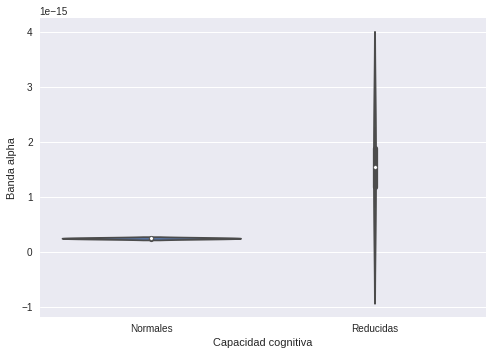

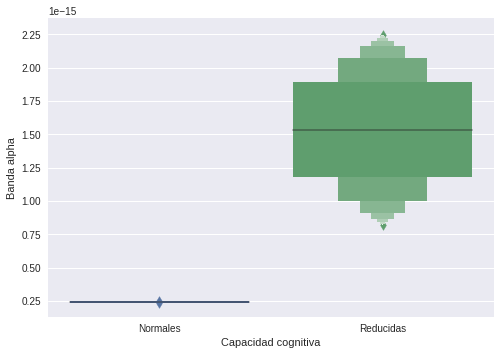

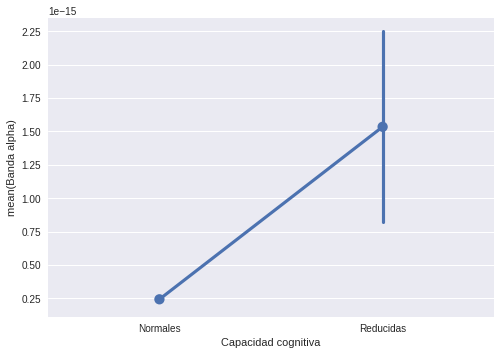

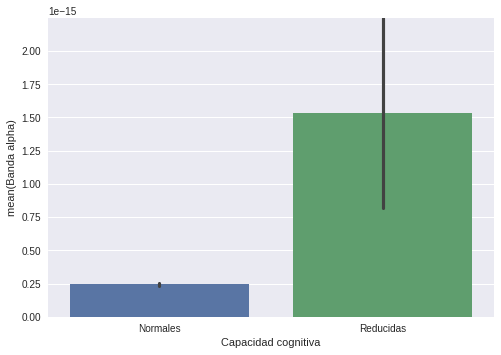

In [27]:
ymin = min(df_alphas['Banda alpha'])
ymax = max(df_alphas['Banda alpha'])
decimo = (ymax - ymin)/len(df_alphas['Banda alpha'])
ymin, ymax = ymin - decimo, ymax + decimo

ax = sns.stripplot(x="Capacidad cognitiva", y="Banda alpha", data=df_alphas)
ax.set_ylim([ymin, ymax])
ax.set_title("Strip plot")
sns.plt.show()

ax = sns.swarmplot(x="Capacidad cognitiva", y="Banda alpha", data=df_alphas)
ax.set_ylim([ymin, ymax])
ax.set_title("Swarm plot")
sns.plt.show()

sns.boxplot(x="Capacidad cognitiva", y="Banda alpha", data=df_alphas)
ax.set_title("Box plot")
sns.plt.show()

sns.violinplot(x="Capacidad cognitiva", y="Banda alpha", data=df_alphas)
ax.set_title("Violin plot")
sns.plt.show()

sns.lvplot(x="Capacidad cognitiva", y="Banda alpha", data=df_alphas)
ax.set_title("Lette value plot")
sns.plt.show()

sns.pointplot(x="Capacidad cognitiva", y="Banda alpha", data=df_alphas)
ax.set_title("Point plot")
sns.plt.show()

sns.barplot(x="Capacidad cognitiva", y="Banda alpha", data=df_alphas)
ax.set_title("Bar plot")
sns.plt.show()

